# Tensorboard로 모델, 데이터, 학습 시각화 하기

pytorch에서는 신경망 학습 내역을 시각화하는 도구인 Tensorboard와 통합되었습니다.

1. 데이터 읽기 및 변환
2. Tensorboard 설정
3. Tensorboard 기록
4. Tensorboard 확인
5. Tensorboard 튜닝
    * 학습 데이터 검사 방법
    * 학습에 따른 모델의 성능 추적 방법
    * 학습이 완료된 모델의 성능을 평가하는 방법

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [11]:
# transforms
transform = transforms.Compose(
    [
        transforms.ToTensor()
        , transforms.Normalize((0.5,),(0.5,))
    ]
)

# datasets
trainset = torchvision.datasets.FashionMNIST(
    './data'
    , download=True
    , train=True
    , transform=transform
)

testset = torchvision.datasets.FashionMNIST(
    './data'
    , download=True
    , train=True
    , transform=transform
)

# dataloader
trainloader = torch.utils.data.DataLoader(
    trainset
    , batch_size=4
    , shuffle=True
    , num_workers=2
)
testloader = torch.utils.data.DataLoader(
    testset
    , batch_size=4
    , shuffle=True
    , num_workers=2
)

# classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandel', 'Shirts', 'Sneaker', 'Bag', 'Ankle Boot')

In [12]:
# image show
def imshow(img, one_channel=False):
    if one_channel: img.mean(dim=0)

    img = img/2 + 0.5 # unnormalize
    npimg = img.numpy()
    if one_channel: plt.imshow(npimg, cmap="Greys")
    else: plt.imshow(np.transpose(npimg, (1,2,0)))

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

net = Net()

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)

# Tensorboard 설정

`torch.utils`의 `tensorboard`를 불러오고, `tensorboard`에 정보를 제공하는 `SummaryWriter`를 정의하여 Tensorboard를 설정합니다.`

In [15]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/fashion_mnist_experiment_1')

# Tensorboard에 기록하기

Tensorboard에 `make_grid`를 사용하여 이미지를 씁니다.

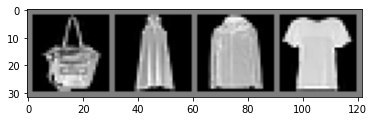

In [16]:
# 임의의 학습 이미지를 가져옵니다
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 그리드를 만듭니다.
img_grid = torchvision.utils.make_grid(images)

# 이미지를 보여줍니다.
imshow(img_grid, one_channel=False)

# Tensorboard에 기록합니다.
writer.add_image('four_fashion_mnist_images', img_grid)

# Tensorboard를 사용하여 모델 살펴보기

In [17]:
writer.add_graph(net, images)
writer.close()

# Tensorboard에 프로젝터 추가하기

`add_embedding` 메소드(method)를 통해 고차원 데이터의 저차원 표현(representation)을 시각화 할 수 있습니다.

In [18]:
# 데이터셋에서 n개의 임의의 데이터포인트(datapoint)와 그에 해당하는 라벨을 선택합니다.
def select_n_random(data, labels, n=100):
    assert len(data)==len(labels)
    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# 임의의 이미지들과 정답 인덱스를 선택합니다.
images, labels = select_n_random(trainset.train_data, trainset.train_labels)

# 각 이미지의 분류 라벨을 가져옵니다.
class_labels = [classes[lab] for lab in labels]

# 임베딩 내역을 기록합니다.
features = images.view(-1, 28 * 28)
writer.add_embedding(
    features
    , metadata=class_labels
    , label_img=images.unsqueeze(1)
)

writer.close()

AttributeError: 'FashionMNIST' object has no attribute 'data'

# Tensorboard로 모델 학습 추적하기

Tensorboard에 학습 중 손실을 기록하는 것 대신에 `plot_classes_preds` 함수를 통해 모델의 예측 결과를 함께 볼 수 있도록 하겠습니다.

In [11]:

def images_to_probs(net, images):
    '''
    학습된 신경망과 이미지 목록으로부터 예측 결과 및 확률을 생성합니다.
    '''

    output = net(images)
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

def plot_classes_preds(net, images, labels):
    '''
    학습된 신경망과 배치로부터 가져온 이미지/라벨을 사용하여 matplotlib Figure를 생성합니다.
    이는 신경망의 예측 결과/확률과 함께 정답을 보여주며, 예측 결과가 맞았는 지 여부에 따라 색을 다르게 표시합니다.
    "image_to_probs" 함수를 사용합니다
    '''

    preds, probs = images_to_probs(net, images)
    # 배치에서 이미지를 가져와 예측 결과/정답과 함께 표시(plot)됩니다.

    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label:{2}".format(
            classes[preds[idx]]
            , probs[idx] * 100.0
            , classes[labels[idx]]), color=("green" if preds[idx]==labels[idx].item() else "red")
        ))
    
    return fig


SyntaxError: unmatched ')' (<ipython-input-11-f8895c62bbc2>, line 29)

In [30]:
running_loss = 0.

for epoch in range(1):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        
        # 변화도(Gradient) 매개 변수를 0으로 설정
        optimizer.zero_grad()

        # 순전파, 역전파, 최적화
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        # 학습 중 Loss 기록
        if i % 1000 = 999:
            writer.add_scalar(
                'training loss'
                , running_loss / 1000,
                epoch * len(trainloader) + i
            )

        # 무작위 mini-batch에 대한 모델의 예측 결과를 보여주도록 matplotlib figure를 기록합니다.
        writer.add_figure(
            'prediction vs actuals'
            , plot_classes_preds(net, inputs, labels)
            , global_step=epoch*len(trainloader)+i
        )

        running_loss = 0.

print('Finish training')


SyntaxError: invalid syntax (<ipython-input-30-a965060b4a71>, line 19)